<a href="https://colab.research.google.com/github/Daciomachado/CU/blob/main/iterative_PFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [227]:
def map_plot(q_ini, q_fin, r, obstaculos, S, SL, E ):


  fig, ax = plt.subplots(figsize=(8,6))

  # Adicionando os obstáculos ao gráfico
  for obs in obstaculos:
      x, y = obs[0]  # Coordenada X e Y
      altura, largura = obs[1]  # Altura e largura
      rect = Rectangle((x, y), largura, altura, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)


  for dotss in S:
    xdotS, ydotS = dotss
    ax.scatter(xdotS, ydotS, color='m', label='q_in', s=20, zorder=0)

  for dotsl in SL:
    x_ySl, _r = dotsl
    xsl, ysl =  x_ySl
    ax.scatter(xsl, ysl, color='c', marker='s', s=30, linewidths= 1.5, zorder=2,  label='q_fin' )

  for bolhas in E:
    x, y = bolhas[0]  # Coordenada X e Y
    re= bolhas[1]
    circulo = plt.Circle((x, y), re, color='y', fill=False, linewidth=2, label='Raio: min(distancias)')
    ax.add_patch(circulo)

  # Adicionando o círculo com o raio igual à menor distância
  circulo = plt.Circle((q_fin[0], q_fin[1]), r, color='b', fill=False, linewidth=2, label='Raio: min(distancias)')
  ax.add_patch(circulo)


  # Adicionando os pontos q_ini e q_fin
  ax.scatter(q_ini[0], q_ini[1], color='g', label='q_ini')  # Ponto inicial
  ax.scatter(q_fin[0], q_fin[1], color='b', label='q_fin')  # Ponto final

  # Configurando o gráfico
  ax.grid(True, alpha=0.7)
  ax.minorticks_on()
  ax.grid(which='minor', linestyle=':', linewidth=0.5)
  ax.set_xlim(0, np.max(obstaculos))
  ax.set_ylim(0, np.max(obstaculos))
  fig.tight_layout()
  ax.set_aspect('auto', 'box')
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Representação")

  plt.show()

In [228]:
def seguimenta(obstaculos):
  seguimentos = []
  for origem, dimensoes in obstaculos:
    x0, y0 = origem
    altura, largura = dimensoes
    x1, y1 = x0 + largura, y0 + altura
    seg = [
          [[x0, y0], [x1, y0]],  # Base
          [[x1, y0], [x1, y1]],  # Lado direito
          [[x1, y1], [x0, y1]],  # Topo
          [[x0, y1], [x0, y0]]   # Lado esquerdo
      ]
    seguimentos.extend(seg)

  return np.array(seguimentos)

In [229]:
def distancia_ponto_reta(P, seguimentos):
  distancias = []
  for A, B in seguimentos:
    AB = B - A
    AP = P - A
    t = np.dot(AP, AB) / np.dot(AB, AB)
    t = max(0, min(1, t))
    projecao = A + t * AB
    distancia = np.linalg.norm(P - projecao)
    distancias.append(distancia)

  return  min(distancias)

In [230]:
def expande_bolha(q, obstaculos):
  seguimentos = seguimenta(obstaculos)
  r = distancia_ponto_reta(q, seguimentos)

  return r

In [231]:
def propaga_espuma(bm_, nb_):
  xy, r = bm_
  xm, ym = xy

  phi1 = np.random.uniform(0, 2 * np.pi, nb_)
  x = r * np.cos(phi1) + xm
  y = r * np.sin(phi1) + ym

  return np.column_stack((x, y))


In [232]:
def distancia_euclidian(x1, y1, x2, y2):
    """Calcula a distância euclidiana entre dois pontos."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [233]:
def Chek_intersc(S_, Espuma, bm, r_min, obstaculos, qfin):

  xy, r_m = bm
  xm, ym = xy
  S_ = S_.tolist()
  print("Verifica Espuma")
  for bolha in Espuma:
    xin, yin = bolha[0]
    r_espuma = bolha[1]
    d_inter = distancia_euclidian(xm, ym, xin, yin)
    r_inter = r_m + r_espuma
    print(f"d(bm {xm, ym }, Be{xin, yin}) < soma_raio  :{d_inter} < {r_inter}")
    if (d_inter > 0.0):
      if (d_inter < r_inter):
        pontos = 0
        while (pontos < (len(S_))):
          p_bolhas = S_[pontos]
          x3, y3 = p_bolhas
          d_ponto_inter = round(distancia_euclidian(x3, y3, xin, yin))
          print(f"d(ponto_bm {x3, y3 }) < r_espuma :{d_ponto_inter} < {r_espuma}")
          if d_ponto_inter < r_espuma:
            print("remove Espuma \n ---")
            S_.remove(p_bolhas)
          else:
            pontos = pontos+1

    print("|||||||||||||||||||||||||||||||||||||||||")

  return S_



In [234]:
from os import remove
def Chek_Filha(Sl_, bm, r_min, obstaculos, qfin):

  xy, r_m = bm
  xm, ym = xy
  xf, yf = qfin
  espuma = []
  remove = []

  l = 0
  while (l< len(Sl_)):

    print(Sl_)
    print("Verifica Pontos de Bm")
    p_bolhas = Sl_[l]
    x1, y1 = p_bolhas
    r_dot =  expande_bolha(p_bolhas, obstaculos)
    print(f"r_dot {x1,y1}: {r_dot}")
    if (distancia_euclidian(xf,yf,x1,y1) < r_dot):
      espuma.append([qfin,r_dot])
      return espuma, "caminho das indias "

    print(f"r > r_min :{r_dot} > {r_min}")
    if  r_dot >= r_min:
      espuma.append([p_bolhas,r_dot])
      Sl_.remove(p_bolhas)
      print("adciona espuma")

      j= 0
      while (j < len(Sl_)):
        dots = Sl_[j]
        x3, y3 = dots
        dis_ponto_bolha = distancia_euclidian(x1,y1, x3,y3)
        print(f"ponto{x3,y3} < bolhaFilha :{dis_ponto_bolha} <= {r_dot}")
        if dis_ponto_bolha <= (r_dot):
          Sl_.remove(dots)
          print("remove")
        else:
          j = j+1

    else:
      print("remove else")
      Sl_.remove(p_bolhas)

    print("________________________")




  return espuma, "caminho dos indios "

In [243]:
# Caso de uso
q_ini = [5, 10]
q_fin = [175,175]
r_min = 2.0
K = 10
N = 2

obstaculos = np.array([
    # Bordas do mapa
    [[-1, -1], [1, 200]],
    [[-1, -1], [200, 1]],
    [[200, 0], [5, 200]],
    [[0, 200], [200, 5]],

    # Estruturas de labirinto
    [[20, 0], [5, 150]],   # Parede vertical esquerda
    [[50, 50], [5, 150]],  # Outra parede vertical mais à direita
    [[80, 0], [5, 100]],   # Mais uma parede vertical
    [[110, 50], [5, 150]], # Vertical perto do meio-direito
    [[140, 0], [5, 200]],  # Grande parede vertical na direita

    [[20, 40], [40, 5]],   # Parede horizontal superior
    [[60, 80], [40, 5]],   # Outra horizontal abaixo
    [[100, 120], [40, 5]], # Mais uma barreira horizontal
    [[140, 160], [40, 5]], # Última horizontal antes do fim

    [[30, 120], [30, 5]],  # Pequeno bloqueio no meio
    [[90, 30], [30, 5]],   # Outro pequeno bloqueio
    [[150, 70], [30, 5]],  # Mais um para dificultar o caminho
])


'''
obstaculos = np.array([
    [[40, 0], [10, 10]],   # Pequeno bloco no canto inferior esquerdo
    [[10, 45], [1, 20]],   # Obstáculo estreito e vertical
    [[5, 20], [10, 2]],    # Pequeno retângulo horizontal
    [[10, 10], [1, 15]],   # Parede estreita
    [[10, 1], [10, 2]],    # Pequeno bloco perto da borda
    [[30, 15], [25, 2]],   # Obstáculo largo e baixo

    [[60, 50], [15, 10]],  # Novo obstáculo no meio do mapa
    [[80, 80], [20, 15]],  # Outro obstáculo criando um desafio
    [[120, 40], [10, 30]], # Bloco vertical médio
    [[150, 100], [25, 25]],# Quadrado maior na parte superior
    [[170, 20], [15, 10]], # Pequeno obstáculo no canto direito

    # Bordas do mapa
    [[-1, -1], [1, 200]],
    [[-1, -1], [200, 1]],
    [[200, 0], [5, 200]],
    [[0, 200], [200, 5]]
])

obstaculos = np.array([
    [[40, 0], [10, 10]],
    [[10, 45], [1, 20]],
    [[5, 20], [10, 2]],
    [[10, 10], [1, 15]],
    [[10, 1], [10, 2]],
    [[30,15], [25, 2]],
    [[-1, 0],[1, 100]],
    [[0,-1], [100, 1]],
    [[100, 0],[1, 100]],
    [[0,100], [100, 1]]
    ])

'''

dts_back = []
dts_escolhidos = []
E = []
L = []
r = expande_bolha(q_fin,obstaculos)
bfin =[q_fin, r]
E.append(bfin)
L.append(bfin)
i = 0

#while ((L) and (i <= 10)):
while (L):
  bm = L[0]
  print(f"ponto:{bm}, i {i}")
  rm = expande_bolha(bm[0][:], obstaculos )
  nb = int(K*(pow(N-1,(rm/r_min))))
  S = propaga_espuma(bm, nb)
  dts_back.extend(S)
  SL = Chek_intersc(S, E, bm, r_min, obstaculos, q_ini)
  SE, caminho = Chek_Filha(SL, bm, r_min, obstaculos, q_ini)
  if caminho == "caminho das indias ":
    print(caminho)
    E.extend(SE)
    dts_escolhidos.extend(SE)
    break
  E.extend(SE)
  L.extend(SE)
  dts_escolhidos.extend(SE)
  L.pop(0)
  i = i+1
  #map_plot(q_ini,q_fin, r, obstaculos, dts_back, dts_escolhidos,  E)


A saída de streaming foi truncada nas últimas 5000 linhas.
d(bm (5.1289062477063854e+153, -7.650197290757353e+152), Be(-7.814437413452998e+77, 4.9655648458805e+77)) < soma_raio  :5.185646968666176e+153 < 5.185646968666176e+153
|||||||||||||||||||||||||||||||||||||||||
d(bm (5.1289062477063854e+153, -7.650197290757353e+152), Be(2.202356092703715e+77, -6.387230433241587e+77)) < soma_raio  :5.185646968666176e+153 < 5.185646968666176e+153
|||||||||||||||||||||||||||||||||||||||||
d(bm (5.1289062477063854e+153, -7.650197290757353e+152), Be(8.595246022840717e+77, 7.879103651487041e+77)) < soma_raio  :5.185646968666176e+153 < 5.185646968666176e+153
|||||||||||||||||||||||||||||||||||||||||
d(bm (5.1289062477063854e+153, -7.650197290757353e+152), Be(-4.198026577814379e+77, -1.2349783358914325e+78)) < soma_raio  :5.185646968666176e+153 < 5.185646968666176e+153
|||||||||||||||||||||||||||||||||||||||||
d(bm (5.1289062477063854e+153, -7.650197290757353e+152), Be(-1.6259632712286731e+78, 8.7604222

OverflowError: (34, 'Numerical result out of range')

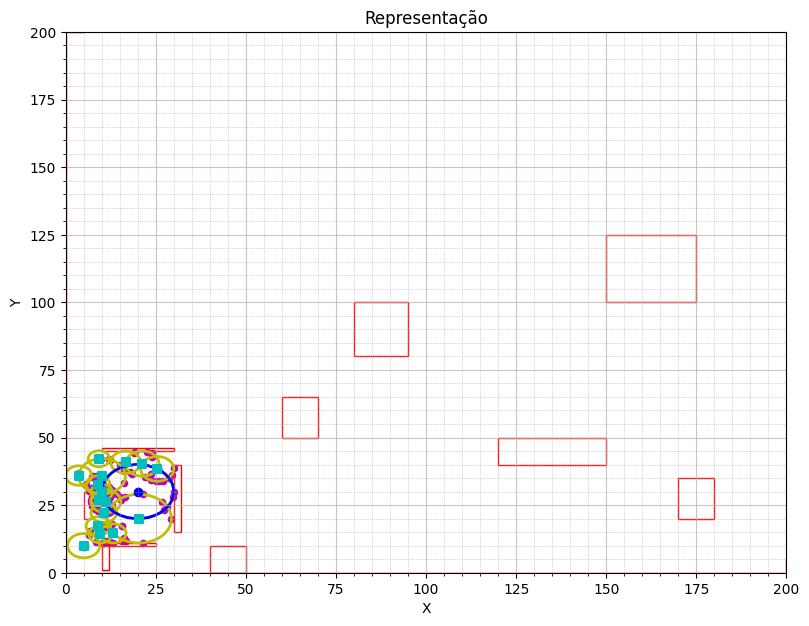

In [242]:
map_plot(q_ini,q_fin, r, obstaculos, dts_back, dts_escolhidos,  E)